<h1><center>Hito 6</center></h1>

<h1><center>Impacto del Jitter</center></h1>

&nbsp;

<center>
Álvaro Garcı́a Garcı́a<br>
Álvaro José Martı́nez Sánchez<br>
José Francisco Castillo Berenguel<br>
</center>
    
    
<hr style="border:1px solid gray"> </hr>


# Introducción

Se ha estudiado en el hito 4 la influencia que tiene el tamaño de chunk en la latencia. En el hito 5 se puso de manifiesto la construcción de un programa intercom que permitiera la transmisión de audio. Por este motivo, resulta relevante el estudio de la latencia que genera la red, ya que, la latencia total $t_u$ viene dada por:

$$t_u=t_p+t_i$$

donde $t_p$ es el <i>tiempo de propagación</i> y $t_i$ es el la latenica generada por intercom.

La siguiente figura muestra el impacto que tiene la latencia de propagación en una comunicación entre dos host, ya que el Host B no puede reproducir directamente el chunk producido por el Host A y viceversa.

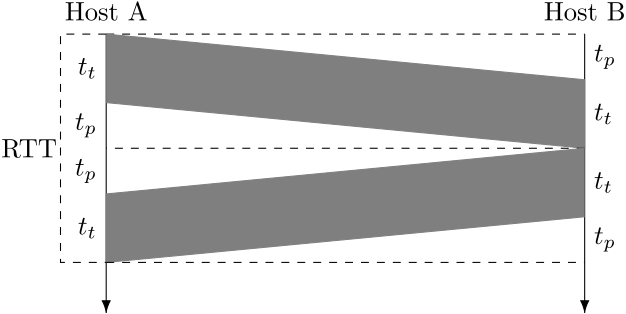

El objetivo de este hito es medir la <i>calidad de experiencia</i> (QoE).

# Caracterización de la latencia en distintos escenarios

Se procede con el estudio de la latencia tanto a nivel local como a nivel remoto.

## Caracterización de la latencia local

In [199]:
!ping localhost -c 100 -s 1024 > localhost_ping.dat

Se calcula la latencia esperada, teniendo en cuanta que el $RTT$ es el doble total de la altencia 

In [1]:
!export LC_NUMERIC=en_US.UTF-8
!grep from < localhost_ping.dat | cut -f 4 -d "=" | cut -f 1 -d " " | awk '{print $1/2}' > localhost_latencies.dat


Se calcula el histograma de las latencias esperadas

In [2]:
import numpy as np 
from scipy import stats
latencies = np.loadtxt("localhost_latencies.dat") 
average_latency = np.average(latencies) 
print("average latency =", average_latency) 
max_latency = np.max(latencies) 
min_latency = np.min(latencies) 
maximum_absolute_deviation = max(max_latency - average_latency, average_latency - min_latency) 
print("maximum absolute deviation (jitter)=", maximum_absolute_deviation) 
correlation_coefficient = stats.pearsonr(latencies, np.roll(latencies, 1))[0] 
print("Pearson correlation coefficient =", correlation_coefficient) 
if correlation_coefficient < 0: 
  print("Correlation coefficient < 0: use 0 (no correlation between RTT samples) in your experiments") 
histogram = np.histogram(latencies) 
np.savetxt("localhost_histogram.dat", histogram[0]) 

average latency = 0.01864
maximum absolute deviation (jitter)= 0.00936
Pearson correlation coefficient = -0.04360317728578671
Correlation coefficient < 0: use 0 (no correlation between RTT samples) in your experiments


Se imprime el histograma calculado

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext gnuplot_kernel
%gnuplot inline svg size 600,600 font "Helvetica,16" 

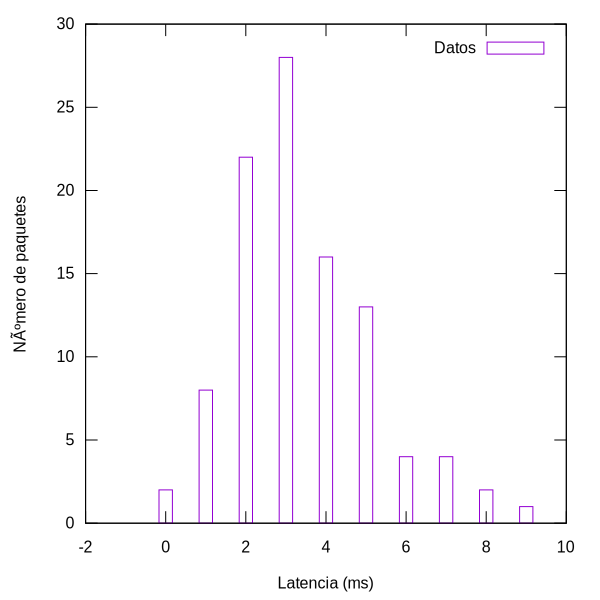

In [4]:
%%gnuplot
set xlabel 'Latencia (ms)'
set ylabel 'Número de paquetes'
plot "localhost_histogram.dat" title 'Datos' with histogram 

En caso de querer verlo mediante una ventana emergente, se debe usar <i>%gnuplot qt</i> al que se puede acompañar con un tamaño recomendado. Posteriormente, se vuelve a llamar a la celda mágica de gnuplot.

In [8]:
%gnuplot qt size 600,600 

In [9]:
%%gnuplot
plot "localhost_histogram.dat" with histogram 

Dependiendo de la situación se obtendrán distintos resultados. Lo ideal es que la latencia fuera constante. Dado que esto no es posible, la siguiente situación ideal es que se presente una distribución con un valor central notorio.

Se procede a visualizar si existe algún modelo que explique la latencia de forma probabilística. Para ello se estudiará el ajuste de los datos del histograma 


Se probarán las siguientes distrubuciones:


1. **Distribución normal:** su función de densidad es:

    $$\dfrac{1}{\sigma \sqrt{2\pi}}e^{-\dfrac{1}{2}\left(\dfrac{x-\mu}{\sigma} \right)^2}$$



2. **Distribución normal logarítmica:** su función de densidad es:

    $$ \dfrac{1}{x\sigma_L \sqrt{2\pi}}e^{\dfrac{-(\ln(x)-\mu_L)^2}{2 \sigma_{L}^{2}}}$$

 donde: $\mu_L = \log \left(\dfrac{\mu^2}{\sqrt{\mu^2 + \sigma^2}}\right)$ $\quad$ y $\quad$ $\sigma_{L}^{2}=\log \left(1 + \dfrac{\sigma^2}{\mu^2} \right)$
 
 

3. **Distribución gamma (experimental):** su función de densidad es:

$$ \lambda e^{-\lambda x}\dfrac{(\lambda x)^{k-1}}{\Gamma(k)} $$

donde $\Gamma$ es la función gamma: $\Gamma(z) = \int_{0}^{\infty} t^{z-1} e^{-t} dt$  $(z \in \mathbb{C})$



**Nota** Se recuerda que la integral impropia (área de toda la curva) de la función de densidad es igual a 1. Esto es:

$$ \int_{-\infty}^{\infty} f(x)dx=1$$


Con motivo de intentar visualizar los histogramas de una forma más adecuada, se utilizará la regla de **Freedman-Diaconis**, la cual dicta que el tamaño de las barras es:

$$anchura = 2 \dfrac{IQR(x)}{\sqrt[3]{x}}$$

donde $IRQ$ es el rango intercuartílico. No obstante, esto no proporciona el número de barras, para ello, partiendo de la anchura, se calcula el número de la forma:

$$num\_barras= \dfrac{max\{x\}-min\{x\}}{anchura}$$

Cargamos los datos en un vector de numpy

In [7]:
data_localhost=np.loadtxt("localhost_latencies.dat")

Definimos las funciones e importamos las librerias necesarias

In [5]:
import scipy.stats as st
from scipy.stats import norm
from scipy.stats import lognorm
import math

def freedman_num_bins(data):
    w_bins = 2*st.iqr(data) / (len(data) ** (1. / 3))
    n_bins = (max(data)-min(data)) / w_bins
    return round(n_bins)

def print_distribution(data, distribution):
    space = np.linspace(min(data),max(data), len(data))
    if (distribution == "normal"):
        param = norm.fit(data)
        normal_pdf = norm.pdf(space, param[0], param[1])
        plt.plot(space, normal_pdf, 'g',linewidth=3, label='Normal')
        
    elif (distribution == "lognormal"):
        param = lognorm.fit(data)
        lognormal_pdf=lognorm.pdf(space, param[0], param[1], param[2])
        #lognormal_pdf=lognorm.pdf(space, param[0], loc=param[1], scale=param[2])
        plt.plot(space, lognormal_pdf, 'r',linewidth=3, label='Lognormal')
        
    elif (distribution == "gamma"):
        param = st.gamma.fit(data)
        gamma_pdf=st.gamma.pdf(space, param[0], param[1], param[2])
        plt.plot(space, gamma_pdf, 'y',linewidth=3, label='Gamma')
        
    elif (distribution == "beta"):
        param = st.beta.fit(data)
        beta_pdf=st.beta.pdf(space, param[0], param[1], param[2], param[3])
        plt.plot(space, beta_pdf, 'o',linewidth=3, label='Beta')
        
    elif (distribution == "weibull"):
        param = st.weibull_min.fit(data)
        print(param)
        weibull_pdf=st.weibull_min.pdf(space, param[0], param[1], param[2])
        print(weibull_pdf)
        plt.plot(space, weibull_pdf, 'm',linewidth=3, label='Weibull')


Antes de proceder, se realizarán algunos ajustes:


1. Normalizar el histograma. De esta forma $\sum_{i=1}^{b} h_i = 1$ donde $b$ es el número de barras y $h_i$ la altura de la barra i-ésima


2. Si las latencias están en fracciones, se realizaŕa un ajuste a una unidad menor mediante el producto con $10^{-3}$. Si por ejemplo están a milisegundos, se pasarán a microsegundos. En caso contrario, el ajuste logaritmico normal se verá afectado

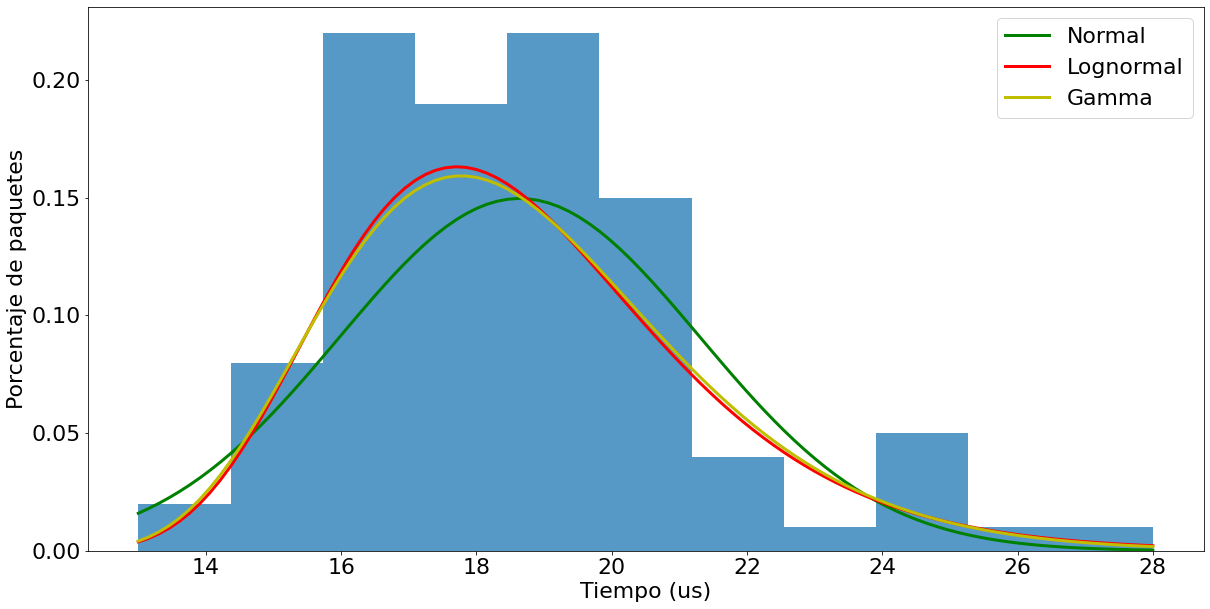

In [22]:
# # Ajuste para la normalización del histograma

data_ms = data_localhost[:]*1000 # a ms
weights = np.ones_like(data_ms)/float(len(data_ms))

# Podemos usar los datos originales, dado que 
# se ha aplicado un homeomorfismo

n_bins = freedman_num_bins(data_localhost)

# Se pinta el histograma
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.hist(data_ms, bins=n_bins, alpha=0.75, weights = weights) #density=True, stacked=True)


# Se pintan las funciones de densidad 

print_distribution(data_ms, "normal")
print_distribution(data_ms, "lognormal")
print_distribution(data_ms, "gamma")

plt.ylabel(ylabel="Porcentaje de paquetes")
plt.xlabel(xlabel="Tiempo (us)")
plt.legend()
plt.show()

De forma experimental, suele verse que las funciones de densidad son "próximas" entre sí. No obstante, el modelo más simple es el dado por una distribución normal. 

## Caracterización de la latencia remota

Se repite el mismo procedimiento, pero usando la dirección IP publica

In [19]:
!ping direccion secreta -c 100 -s 1024 > ping-1024b-publica.dat

In [9]:
!export LC_NUMERIC=en_US.UTF-8 # Use "." instead of "," for the decimal separator
!grep from < ping-1024b-publica.dat | cut -f 4 -d "=" | cut -f 1 -d " " | awk '{print $1/2}' > public_latencies.dat

Realizamos la caracterizaciones de los datos obtenidos

In [10]:
import numpy as np 
from scipy import stats 
latencies = np.loadtxt("public_latencies.dat") 
average_latency = np.average(latencies) 
print("average latency =", average_latency) 
max_latency = np.max(latencies) 
min_latency = np.min(latencies) 
maximum_absolute_deviation = max(max_latency - average_latency, average_latency - min_latency) 
print("maximum absolute deviation (jitter)=", maximum_absolute_deviation) 
correlation_coefficient = stats.pearsonr(latencies, np.roll(latencies, 1))[0] 
print("Pearson correlation coefficient =", correlation_coefficient) 
if correlation_coefficient < 0: 
  print("Correlation coefficient < 0: use 0 (no correlation between RTT samples) in your experiments") 
histogram = np.histogram(latencies) 
np.savetxt("public_latencies_histogram.dat", histogram[0])

average latency = 31.232999999999997
maximum absolute deviation (jitter)= 5.882999999999996
Pearson correlation coefficient = 0.0037514356248851645


Se muestra el histograma usando gnuplot

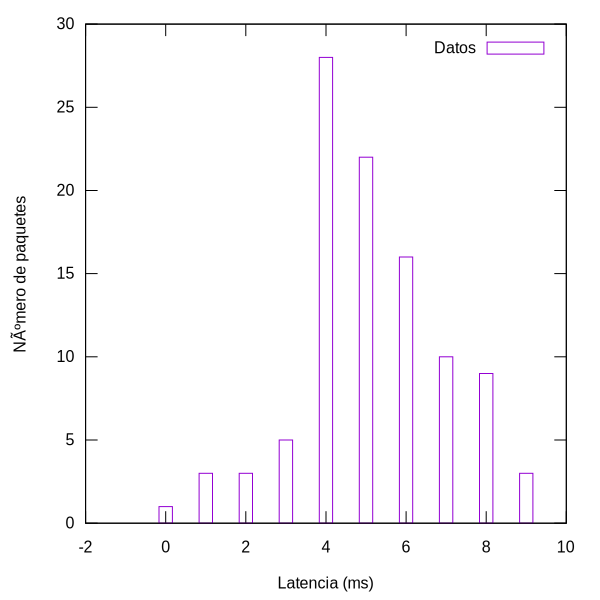

In [11]:
%%gnuplot
set xlabel 'Latencia (ms)'
set ylabel 'Número de paquetes'
plot "public_latencies_histogram.dat" title 'Datos' with histogram

Se realiza la caracterización de la distribución. Primero cargamos de nuevo los datos en un nuevo array de numpy

In [12]:
data_remote=np.loadtxt("public_latencies.dat")

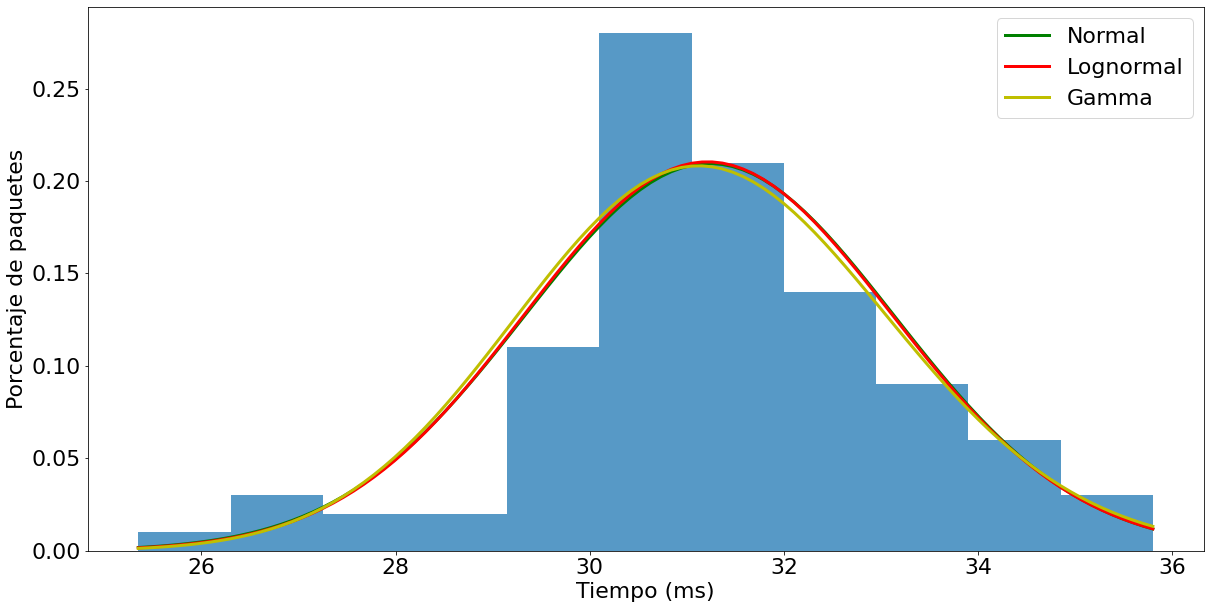

In [21]:
# # Ajuste para la normalización del histograma

data_rem = data_remote[:]# *1000
# weights = np.ones_like(data_ms) / len(data_ms)

weights = np.ones_like(data_rem)/float(len(data_rem))

# Podemos usar los datos originales, dado que 
# se ha aplicado un homeomorfismo

n_bins = freedman_num_bins(data_rem)

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})

# Se pinta el histograma

plt.hist(data_rem, bins=n_bins, alpha=0.75, weights=weights) # density=True, stacked=True)

# Se pintan las funciones de densidad 

print_distribution(data_rem, "normal")
print_distribution(data_rem, "lognormal")
print_distribution(data_rem, "gamma")


plt.ylabel(ylabel="Porcentaje de paquetes")
plt.xlabel(xlabel="Tiempo (ms)")
plt.legend()
plt.show()

### Caracterización total

Para realizar la caracterización de toda la conexión, se procede a obtener las latencias de ambos interlocutores con sus routers, las cuales serán sumadas con la latencia entre routers. Se procede a cargar los resutlados de ping del compañero a su router para tratarlos

In [49]:
!export LC_NUMERIC=en_US.UTF-8 # Use "." instead of "," for the decimal separator
!grep from < ping-interlocutor-router.dat | cut -f 4 -d "=" | cut -f 1 -d " " | awk '{print $1/2}' > interlocutor_router_latencies.dat

In [14]:
data_interlocutor_router=np.loadtxt("interlocutor_router_latencies.dat")

average latency = 43.21300000000001
maximum absolute deviation (jitter)= 6.886999999999986
Pearson correlation coefficient = 0.0037514356248851645


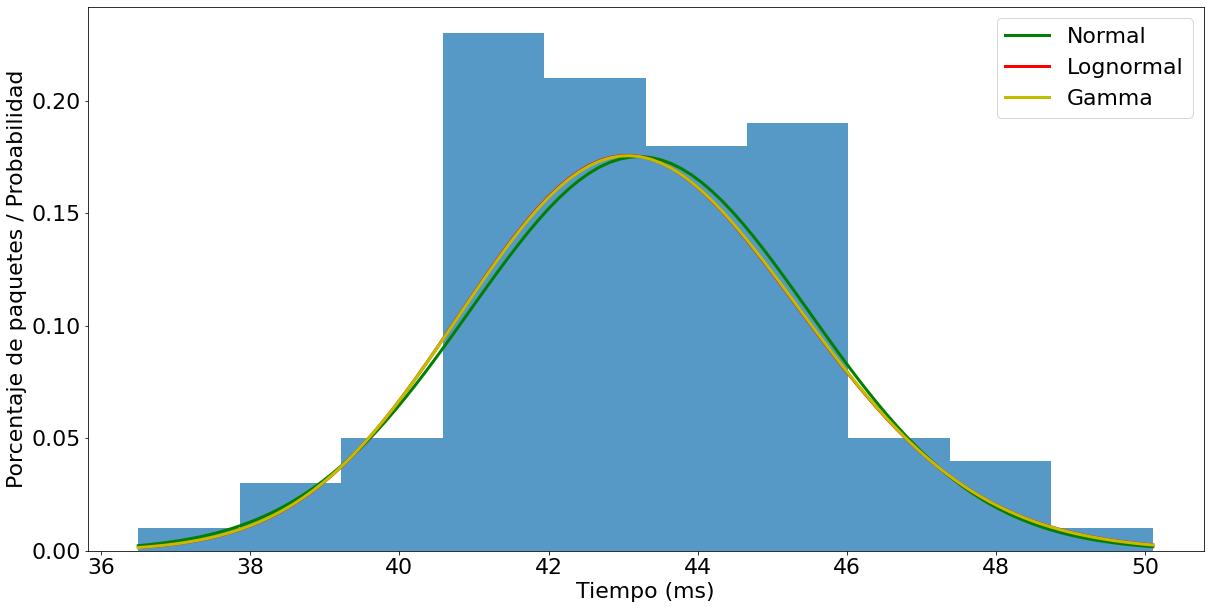

In [15]:

data_tot = data_remote[:] + data_interlocutor_router[:]# *1000

# Ajuste para la normalización del histograma
weights = np.ones_like(data_tot)/float(len(data_tot))

# Podemos usar los datos originales, dado que 
# se ha aplicado un homeomorfismo

# Se pinta el histograma
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})

n_bins = freedman_num_bins(data_tot)

bar=plt.hist(data_tot, bins=n_bins, alpha=0.75, weights = weights)# density=True, stacked=True)

# Se pinta información de la caracterización. 

average_latency = np.average(data_tot) 
print("average latency =", average_latency)
max_latency = np.max(data_tot) 
min_latency = np.min(data_tot) 
maximum_absolute_deviation = max(max_latency - average_latency, average_latency - min_latency)
print("maximum absolute deviation (jitter)=", maximum_absolute_deviation) 
correlation_coefficient = stats.pearsonr(latencies, np.roll(latencies, 1))[0]
print("Pearson correlation coefficient =", correlation_coefficient) 
if correlation_coefficient < 0: 
  print("Correlation coefficient < 0: use 0 (no correlation between RTT samples) in your experiments")



# Se pintan las funciones de densidad 

print_distribution(data_tot, "normal")
print_distribution(data_tot, "lognormal")
print_distribution(data_tot, "gamma")

#print(data_tot[:] * weights[:])
plt.ylabel(ylabel="Porcentaje de paquetes")
plt.xlabel(xlabel="Tiempo (ms)")
plt.legend()
plt.show()

# Cuantificación de la Calidad de Experiencia (QoE)


Se procede a medir la QoE mediante el sistema de clasificación:

1. **Perfecto**
 
2. **Bueno** 

4. **Aceptable**

3. **Malo**

9. **Paupérrimo**

## Local

Se invoca directamente el programa `minimal.py` con los valores por defecto. Los resultados de su uso en local se podrían catalogar como *perfectos*, sin embargo, puede producirse cierta latencia con el tiempo por la acumuación de paquetes. Dicha acumulación puede verse mediante  `netstat -ulpn`

De forma general, la comunicación es perfecta.

## En internet

Se procede a emular la latencia y la pérdida de paquetes. Para ello, primero se debe ver la configuración

In [59]:
!tc qdisc show dev lo 

qdisc noqueue 0: root refcnt 2 


Mediante los parámetros de la caracterización de la conexión de la sección anterior, se procede a generar una configuración que permita su emulación mediante el comando `tc`.

In [16]:
from getpass import getpass
!echo {getpass()} | sudo -S tc qdisc add dev lo root netem delay 43.75ms 6.88ms 0.375% distribution normal


········
[sudo] password for cobeguel: 

In [17]:
!echo {getpass()} | sudo -S tc qdisc show dev lo

········
[sudo] password for cobeguel: qdisc netem 8001: root refcnt 2 limit 1000 delay 43.7ms  6.9ms 0.375%


A continuación, se lanza el programa `minimal.py`. Dado que se ha utilizado un tamaño de bloque de 1024 bytes, se procede a utilizar los valores por defecto.

|                                Configuración                                 |  Resultado |
|:----------------------------------------------------------------------------:|:----------:|
|                                    Local                                     |  Perfecto  |
| Remoto (1)<br>Promedio $=49.75$<br>Desviación $= 65.44$<br>Pearson $= 7\%$   |    Mala    |
|Remoto (1)<br>Promedio $=43.75$<br>Desviación $= 6.88$<br>Pearson $= 0.32\%$  |   Bueno    |
|                               Pérdida $10 \%$                                |    Mala    |
|                               Pérdida $25 \%$                                | Paupérrimo |


Por último, se borra la regla implementada

In [18]:
!echo {getpass()} | sudo -S tc qdisc delete dev lo root netem delay 43.75ms 6.88ms 0.375% distribution normal

········
[sudo] password for cobeguel: 

Comprobamos que se ha borrado

In [19]:
!tc qdisc show dev lo 

qdisc noqueue 0: root refcnt 2 
